# Imports e Configurações
Este bloco centraliza:
- Imports de bibliotecas core (numpy, tensorflow/keras, matplotlib, etc.)
- Fixação de seeds para reprodutibilidade
- Configs úteis (ex.: supressão de warnings do TF, modo inline para gráficos)

Obs.: Vamos usar Transfer Learning com MobileNetV2 mais adiante.
Por isso, o preprocess_input correto virá de `keras.applications.mobilenet_v2`.

In [13]:
%matplotlib inline
import os
import zipfile
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

import logging, warnings
warnings.filterwarnings("ignore")
logging.getLogger("tensorflow").setLevel(logging.ERROR)

print(tf.__version__)
print("Config Ok, ambiente preparado")

2.19.0
Config Ok, ambiente preparado


# Download e Extração do Dataset (Cats vs Dogs)
Usaremos o dataset "cats_and_dogs_filtered" público do Google

In [3]:
DATA_URL = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"

print("Baixando dataset Cats vs Dogs (filtered)...")
zip_path = tf.keras.utils.get_file("cats_and_dogs_filtered.zip", origin=DATA_URL)
base_extract_dir = os.path.dirname(zip_path)
extract_path = os.path.join(base_extract_dir, "cats_and_dogs_filtered")

# Extração
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(base_extract_dir)

print("Extraído em:", base_extract_dir)
print("Entradas nesta pasta:", sorted(os.listdir(base_extract_dir))[:10])

# Diretórios principais de treino e validação
train_dir = os.path.join(extract_path, "train")
val_dir   = os.path.join(extract_path, "validation")

assert os.path.isdir(train_dir), f"Diretório de treino não encontrado: {train_dir}"
assert os.path.isdir(val_dir),   f"Diretório de validação não encontrado: {val_dir}"

print("\nDiretórios definidos:")
print(" - Train     :", train_dir)
print(" - Validation:", val_dir)

# Detectar categorias automaticamente a partir das subpastas (train)
categories = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
categories = sorted(categories)
num_classes = len(categories)

print("\nCategorias detectadas:", categories)
print("n_classes:", num_classes)


Baixando dataset Cats vs Dogs (filtered)...
68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Extraído em: /root/.keras/datasets
Entradas nesta pasta: ['cats_and_dogs_filtered', 'cats_and_dogs_filtered.zip']

Diretórios definidos:
 - Train     : /root/.keras/datasets/cats_and_dogs_filtered/train
 - Validation: /root/.keras/datasets/cats_and_dogs_filtered/validation

Categorias detectadas: ['cats', 'dogs']
n_classes: 2


Resumo do Setup & Dados

- Seeds fixadas (42) e logs silenciosos - execuções reprodutíveis e saída limpa.

- Dataset Cats vs Dogs (filtered) baixado e extraído em ~/.keras/datasets.

- Diretórios confirmados: train/ e validation/.

- Classes detectadas automaticamente: ['cats', 'dogs'] - n_classes = 2.


# Visualização rápida de amostras
Este bloco apenas carrega 8 imagens aleatórias do diretório de treino e plota lado a lado. Não há transformação/augment aqui - é um sanity check visual da extração/estrutura.



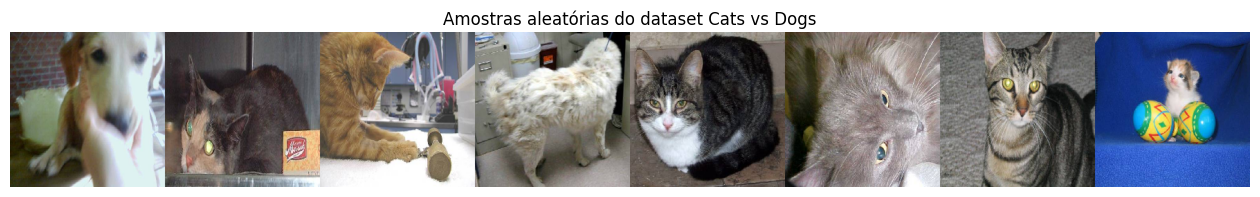

In [5]:
def sample_images_grid(root_dir, n=8, target_size=(224, 224), seed=SEED):
    rng = random.Random(seed)

    # Coleta caminhos de todas as imagens no train_dir
    all_imgs = []
    for dp, _, files in os.walk(root_dir):
        for f in files:
            if os.path.splitext(f)[1].lower() in {".jpg", ".jpeg", ".png"}:
                all_imgs.append(os.path.join(dp, f))
    if len(all_imgs) == 0:
        print("Nenhuma imagem encontrada em:", root_dir)
        return

    idx = [rng.randrange(0, len(all_imgs)) for _ in range(n)]
    imgs = [image.load_img(all_imgs[i], target_size=target_size) for i in idx]

    concat = np.concatenate([np.asarray(img) for img in imgs], axis=1)

    plt.figure(figsize=(16, 4))
    plt.imshow(concat)
    plt.axis("off")
    plt.title("Amostras aleatórias do dataset Cats vs Dogs")
    plt.show()

# Visual
sample_images_grid(train_dir, n=8, target_size=(224, 224))


# Pré-processamento e Splits

Nesta etapa:
- Carregamos todas as imagens do diretório (train/validation) com `preprocess_input`
- Fazemos a divisão em treino, validação e teste manualmente (70/15/15)
- Normalizamos os dados de acordo com a escala esperada pelo modelo pré-treinado
- Transformamos os rótulos em one-hot encoding

Observação:
Como estamos usando Transfer Learning, não dividiremos novamente por 255.
O `preprocess_input()` da MobileNetV2 já aplica o escalonamento correto em [-1, 1].

Carregando imagens do dataset...


Classe: dogs: 100%|████████████████████████| 1000/1000 [00:02<00:00, 437.65it/s]



Total de imagens carregadas: 2000
Treino: 1400 | Validação: 300 | Teste: 300
Formato das imagens: (1400, 224, 224, 3)
Rótulos convertidos em one-hot:
 - y_train: (1400, 2)
 - y_val  : (300, 2)
 - y_test : (300, 2)


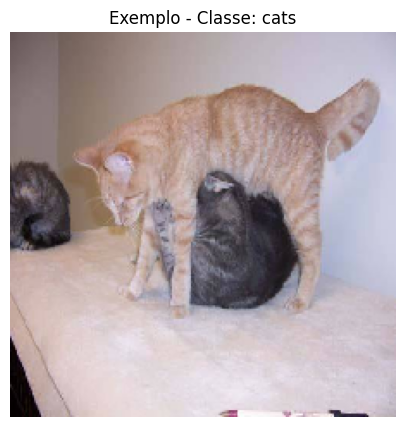

In [7]:
def load_image(path, target_size=(224, 224)):

    img = image.load_img(path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return np.array(x[0], dtype=np.float32)

# Reunir todas as imagens e rótulos
print("Carregando imagens do dataset...")
data = []
for class_index, class_name in enumerate(categories):
    class_dir = os.path.join(train_dir, class_name)
    imgs = [os.path.join(dp, f)
            for dp, _, files in os.walk(class_dir)
            for f in files
            if os.path.splitext(f)[1].lower() in {".jpg", ".jpeg", ".png"}]

    for img_path in tqdm(imgs, desc=f"Classe: {class_name}", ncols=80):
        try:
            arr = load_image(img_path)
            data.append({"x": arr, "y": class_index})
        except Exception as e:
            # Ignora imagens corrompidas ou ilegíveis
            continue

print(f"\nTotal de imagens carregadas: {len(data)}")

# Embaralhar e dividir (70% treino, 15% validação, 15% teste)
random.shuffle(data)

train_split = 0.7
val_split = 0.15

idx_train = int(train_split * len(data))
idx_val = int((train_split + val_split) * len(data))

train_data = data[:idx_train]
val_data   = data[idx_train:idx_val]
test_data  = data[idx_val:]

# Separar features e labels
x_train = np.array([d["x"] for d in train_data])
y_train = np.array([d["y"] for d in train_data])

x_val   = np.array([d["x"] for d in val_data])
y_val   = np.array([d["y"] for d in val_data])

x_test  = np.array([d["x"] for d in test_data])
y_test  = np.array([d["y"] for d in test_data])

print(f"Treino: {len(x_train)} | Validação: {len(x_val)} | Teste: {len(x_test)}")
print("Formato das imagens:", x_train.shape)

# One-hot encoding dos rótulos
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val   = keras.utils.to_categorical(y_val, num_classes)
y_test  = keras.utils.to_categorical(y_test, num_classes)

print("Rótulos convertidos em one-hot:")
print(" - y_train:", y_train.shape)
print(" - y_val  :", y_val.shape)
print(" - y_test :", y_test.shape)

# Sanity check: visualizar uma imagem e seu rótulo
idx = random.randint(0, len(x_train) - 1)
plt.imshow((x_train[idx] + 1) / 2)
plt.axis("off")
plt.title(f"Exemplo - Classe: {categories[np.argmax(y_train[idx])]}")
plt.show()


# Criação e Compilação do Modelo com Transfer Learning

Aqui aplicamos o conceito central de Transfer Learning:
utilizamos uma rede já treinada (no caso, a MobileNetV2, treinada no ImageNet) como extratora de características e adicionamos camadas densas para a classificação binária (gatos vs. cachorros).

Etapas:
1. Carregar a MobileNetV2 sem a "cabeça" de classificação original (`include_top=False`)
2. Congelar suas camadas convolucionais para preservar o aprendizado
3. Empilhar novas camadas densas específicas do nosso problema
4. Compilar o modelo com função de perda e métricas adequadas

In [9]:


# Carregar o modelo base (pré-treinado no ImageNet)
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Congelar as camadas convolucionais para preservar o aprendizado original
base_model.trainable = False

# Construção do modelo sequencial
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compilação do modelo
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)

# Exibir resumo
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,434 (9.87 MB)

 Trainable params: 328,450 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Transfer Learning com MobileNetV2 - Análise do `model.summary()`

Saída: MobileNetV2 (no top) + GAP + Dense(256, ReLU) + Dropout(0.3) + Dense(2, Softmax).
Contagem de parâmetros:

* Total: 2.586.434 (~9.87 MB)
* Treináveis: 328.450 (topo)
* Não-treináveis 2.257.984 (backbone congelado)

---

## Arquitetura - o que significa cada bloco

* `MobileNetV2 (None, 7, 7, 1280)`
  Backbone pré-treinado no ImageNet atuando como extrator de features. Mantido congelado para preservar conhecimento geral (bordas, texturas, formas) e acelerar o treino.
* `GlobalAveragePooling2D - (None, 1280)`
  Faz a média espacial dos mapas 7×7 - vetor de 1280. Reduz parâmetros vs. `Flatten` e ajuda na generalização.
* `Dense(256, ReLU)`
  Camada totalmente conectada compacta para aprender um limiar de decisão específico de cats vs dogs.
* `Dropout(0.3)`
  Regularização para segurar overfitting no topo.
* `Dense(2, Softmax)`
  Saída binária com probabilidade para cada classe.

---

## Por que essas escolhas são espertas

* Base congelado = menos risco de overfitting com ~2k imagens + treino mais rápido.
* GAP no lugar de `Flatten` = menos parâmetros e melhor robustez a variações espaciais.
* Topo leve (256 + Dropout) = capacidade suficiente sem inflar o modelo.

---

## Compilação (intenção)

* Otimizador: `Adam(1e-4)` - passo pequeno, estável para treinar só a cabeça.
* Loss: `categorical_crossentropy` - compatível com one-hot.
* Métricas: `accuracy` (intuitiva) + `AUC` (mede qualidade do ranking de probabilidades).

Expectativa inicial: accuracy e AUC devem subir rápido nas primeiras épocas, graças às features já prontas.

#Treinamento do Modelo (Feature Extractor Congelado)

Nesta primeira fase de treinamento, as camadas convolucionais da MobileNetV2 estão congeladas. Isso significa que apenas as camadas densas adicionadas ao final serão treinadas.

Essa abordagem permite que o modelo use os padrões visuais gerais aprendidos no ImageNet(bordas, texturas, formas básicas) e adapte apenas a parte superior para a tarefa de distinguir entre gatos e cachorros.

Também aplicamos early stopping para evitar overfitting e checkpoint para salvar o melhor modelo.


In [11]:
# EarlyStopping: interrompe o treino se a perda de validação não melhorar
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# ModelCheckpoint: salva o melhor modelo com base na validação
checkpoint = ModelCheckpoint(
    'mobilenetv2_feature_extractor.keras',
    monitor='val_loss',
    save_best_only=True
)

# Início do treinamento
print("Treinando modelo com base congelada...")
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[early_stop, checkpoint],
    verbose=1
)


Treinando modelo com base congelada...
Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8399 - auc: 0.9079 - loss: 0.3706 - val_accuracy: 0.9767 - val_auc: 0.9948 - val_loss: 0.0955
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.9729 - auc: 0.9927 - loss: 0.1010 - val_accuracy: 0.9767 - val_auc: 0.9971 - val_loss: 0.0706
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.9814 - auc: 0.9989 - loss: 0.0557 - val_accuracy: 0.9767 - val_auc: 0.9972 - val_loss: 0.0645
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.9847 - auc: 0.9990 - loss: 0.0464 - val_accuracy: 0.9800 - val_auc: 0.9968 - val_loss: 0.0634
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9889 - auc: 0.9994 - loss: 0.0347 - val_accuracy: 0.9800 - val_auc: 0.9980 - val_loss: 0.0561
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.9954 - auc: 0.9996 - loss: 0.0278 - val_accuracy: 0.9800 - val_auc: 0.9977 - val_loss: 0.0565
Epoch 7/10
4

Treino (base congelada) - análise em MD
Callbacks usados

EarlyStopping (monitor='val_loss', patience=3 restore_best_weights=True): evita overfitting parando quando a validação deixa de melhorar, ainda restaura os melhores pesos.

ModelCheckpoint (save_best_only=True): salva o melhor ponto com base em val_loss.

Na prática: o EarlyStopping não disparou porque a val_loss continuou melhorando até o fim (época 10). O checkpoint salvou o último/best.

Dinâmica do aprendizado (épocas 1-10)

Kickstart forte:

Epoch 1: acc=0.84, auc=0.91, loss=0.37

Val: val_acc=0.9767, val_auc=0.9948, val_loss=0.0955
- O topo já aprende muito rápido usando as features da MobileNetV2.

Estabilização da validação:
val_acc ficou ~0.98 praticamente o treino inteiro; val_auc ~0.998 (altíssimo), e val_loss caiu de 0.0955 - 0.0466 (melhoria consistente, com um mini-solavanco na época 6).

Treino quase perfeito no final:
Epoch 10: acc=0.9985, auc≈1.0000, loss=0.0132.

Leitura:

O gap entre train e val é pequeno (val acc ~0.98 estável) - overfitting baixo mesmo com acc de treino quase 1.

AUC ~0.998 desde cedo indica que o modelo ranqueia muito bem as classes; os poucos erros tendem a ser casos limítrofes.

Qualidade do modelo (congelado)

Convergência rápida + validação alta - o topo consegue separar cats vs. dogs com as features fixas.

Bons sinais de generalização: val_loss cai até o fim, sem divergência das curvas.

Tempo por época

Variou entre ~75s e ~134s. Essa oscilação é normal (I/O, cache, agendamento de GPU/CPU).

Conclusões (fase 1 - base congelada)

Setup funcionou muito bem: val_acc ≈ 98.3% e val_auc ≈ 0.999.

Nenhum indício forte de overfitting.

Como a validação estabilizou em acurácia (apesar da val_loss seguir caindo), provável teto do extrator congelado.

## Visualização das curvas de treino

Os gráficos abaixo mostram:
- A evolução da acurácia (accuracy) no treino e validação.
- A evolução da perda (loss) no treino e validação.

Idealmente, ambas devem convergir sem sinais fortes de overfitting.


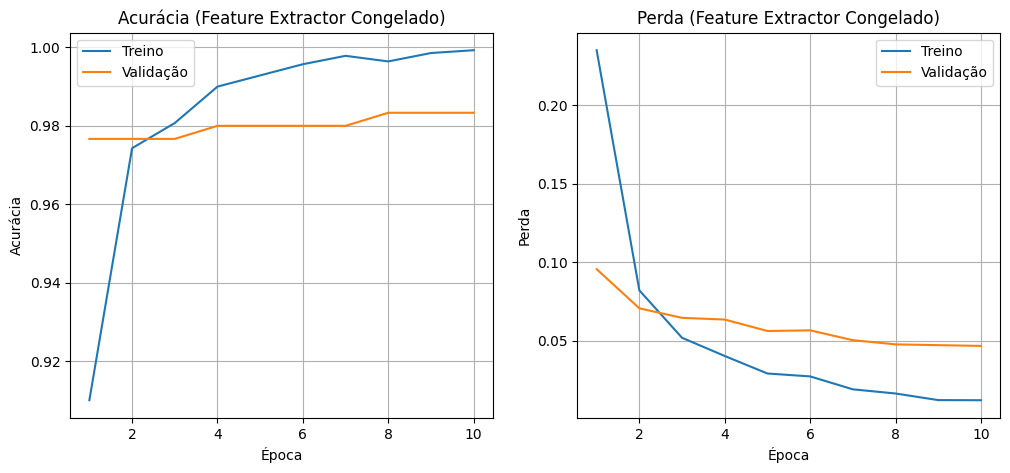

In [12]:
def plot_history(history, title_suffix="(Feature Extractor Congelado)"):
    acc     = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss    = history.history['loss']
    val_loss= history.history['val_loss']
    epochs  = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Treino')
    plt.plot(epochs, val_acc, label='Validação')
    plt.title(f'Acurácia {title_suffix}')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Treino')
    plt.plot(epochs, val_loss, label='Validação')
    plt.title(f'Perda {title_suffix}')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend()

    plt.show()

plot_history(history)


Curvas de treino - leitura rápida e honesta
Acurácia

Treino: sobe liso de ~0.91 até ≈1.00 - sinal de que o topo aprendeu bem usando as features da MobileNetV2 congelada.

Validação: fica estável em ~0.98-0.983 ao longo das épocas, com leve ganho por volta da época 7-8.

Gap pequeno (train ~1.00 vs val ~0.983): indica boa generalização; nada de overfitting pesado.

Tradução: o modelo “memoriza” bem o treino (normal com topo pequeno) e generaliza forte na validação; o teto aparente é ~98.3% com a base congelada.

Perda (Loss)

Treino: cai continuamente (≈0.23 - ≈0.014), consistente com a acurácia batendo 1.0.

Validação: desce de ~0.095 - ~0.046 e estabiliza, sem inversão de tendência.

O declínio contínuo da val_loss mesmo com val_acc “travada” sugere melhora na calibragem/confiança das previsões (margem maior entre as classes) sem necessariamente converter em mais acertos por limite de casos ambíguos.

O que essas curvas contam sobre o modelo

Aprendizado eficiente: transfer learning entregou muito em poucas épocas.

Baixo overfitting: gap contido e val_loss descendo até o fim.

Possível teto do extrator congelado: acurácia de validação satura ~0.983; ganhos adicionais podem exigir ajustar o backbone.

## Avaliação no conjunto de teste

Após o treino, avaliamos o modelo em dados nunca visto (conjunto de teste). Essa métrica fornece uma estimativa real da capacidade de generalização do modelo.

Avaliação no TESTE -> Loss: 0.0557 | Accuracy: 0.9800 | AUC: 0.9954

Classification Report:
              precision    recall  f1-score   support

        cats       0.99      0.97      0.98       143
        dogs       0.97      0.99      0.98       157

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



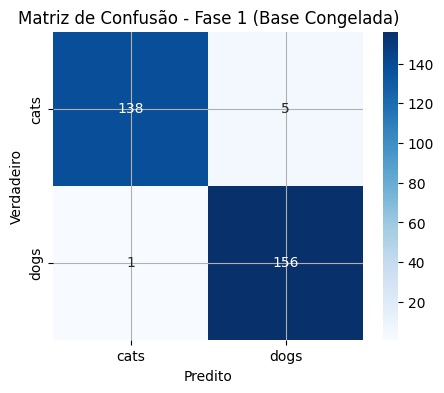

In [14]:



# Avaliação
test_loss, test_acc, test_auc = model.evaluate(x_test, y_test, verbose=0)
print(f"Avaliação no TESTE -> Loss: {test_loss:.4f} | Accuracy: {test_acc:.4f} | AUC: {test_auc:.4f}")

# Predições
y_pred_proba = model.predict(x_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test, axis=1)

# Relatório de classificação
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=categories))

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.title("Matriz de Confusão - Fase 1 (Base Congelada)")
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.show()


Métricas globais

Accuracy: 0.9800

AUC: 0.9954

Loss: 0.0557

Leitura rápida: performance muito sólida; AUC altíssima indica que o modelo ranqueia as classes com confiança - as poucas confusões são casos limítrofes.

Matriz de confusão (300 amostras)
Verdadeiro \ Predito	cats	dogs
cats (143)	138	5
dogs (157)	1	156

Erros totais: 6

5 gatos - dogs (FN de cats)

1 cachorro - cats (FP de cats)

Por classe (do classification report)

cats

Precision ~ 0.99 (138/139) - quase nenhum falso positivo.

Recall ~ 0.97 (138/143) - perde 5 gatos para “dogs”.

dogs

Precision ~ 0.97 (156/161) - alguns falsos positivos vindos de “cats”.

Recall ~ 0.99 (156/157) - recupera praticamente todos os dogs.

Interpretação: o modelo está um pouco mais conservador para “cats” (altíssima precisão), sacrificando alguns recalls de gatos. Para “dogs” é o inverso: recall altíssimo, com uma leve queda na precisão.

O que esses números contam

Generalização boa: accuracy 98% em teste (dados nunca vistos).

Probabilidades bem calibradas: AUC ~0.995 sugere separação limpa entre classes.

Erros assimétricos: mais gatos confundidos com dogs do que o contrário - possivelmente casos de:

gatos de cor/porte que lembram dogs em close-up,

poses encolhidas/oclusões,

iluminação/ruído de fundo que “apagam” traços felinos.

# Fine-Tuning (Ajuste Fino da MobileNetV2)

Nesta fase, "descongelamos" uma parte da MobileNetV (camadas finais), permitindo que elas sejam ajustadas ao nosso dataset específico.

Estratégia:
- Mantemos a maioria das camadas ainda congeladas (para não perder o aprendizado geral)
- Descongelamos apenas as últimas ~20 camadas convolucionais
- Reduzimos a *learning rate* para evitar mudanças bruscas nos pesos pré-treinados

Isso é chamado de Fine-Tuning Controlado, e melhora o desempenho final.


In [16]:
# Descongelar parcialmente a base convolucional
base_model.trainable = True

# Congelar as camadas iniciais e liberar apenas as últimas 20 para ajuste fino
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Confirmar quantas camadas estão treináveis
trainable_layers = sum([1 for l in base_model.layers if l.trainable])
print(f"Camadas treináveis após o ajuste: {trainable_layers} / {len(base_model.layers)}")

# Recompilar o modelo com *learning rate* menor
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)


Camadas treináveis após o ajuste: 20 / 154


## Re-treinamento (Fine-Tuning)

Agora treinamos novamente o modelo, com uma taxa de aprendizado menor, permitindo que ele ajuste suavemente as camadas superiores da MobileNetV2.


In [17]:
checkpoint_ft = ModelCheckpoint(
    'mobilenetv2_finetuned.keras',
    monitor='val_loss',
    save_best_only=True
)

print("Treinando modelo (fase Fine-Tuning)...")
history_ft = model.fit(
    x_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[early_stop, checkpoint_ft],
    verbose=1
)


Treinando modelo (fase Fine-Tuning)...
Epoch 1/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.8687 - auc: 0.9465 - loss: 0.3476 - val_accuracy: 0.9933 - val_auc: 0.9990 - val_loss: 0.0409
Epoch 2/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step - accuracy: 0.9725 - auc: 0.9978 - loss: 0.0670 - val_accuracy: 0.9867 - val_auc: 0.9989 - val_loss: 0.0428
Epoch 3/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.9864 - auc: 0.9993 - loss: 0.0439 - val_accuracy: 0.9900 - val_auc: 0.9989 - val_loss: 0.0429
Epoch 4/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.9940 - auc: 0.9999 - loss: 0.0295 - val_accuracy: 0.9933 - val_auc: 0.9989 - val_loss: 0.0426


Fine-Tuning - análise.

Primeiro, um detalhe crucial de ordem de execução

Apesar do print dizer “Treinando modelo (fase Fine-Tuning)…”, o descongelamento da base (base_model.trainable = True + liberar as últimas 20 camadas) e a recompilação com LR=1e-5 aconteceram depois do model.fit(...). Ou seja: as 4 épocas listadas ainda foram com a base congelada (na prática, continuação do treino do topo). O fine-tuning de verdade só fica habilitado após a recompilação.

Resultado: os números abaixo não refletem alterações nos pesos da MobileNetV2; refletem só ajustes no topo.

📈 Métricas reportadas (base ainda congelada)

Época 1: acc=0.8687, auc=0.9465, loss=0.3476 - val_acc=0.9933, val_auc=0.9990, val_loss=0.0409

Época 2: acc=0.9725, auc=0.9978, loss=0.0670 - val_acc=0.9867, val_loss=0.0428

Época 3: acc=0.9864, auc=0.9993, loss=0.0439 - val_acc=0.9900, val_loss=0.0429

Época 4: acc=0.9940, auc=0.9999, loss=0.0295 - val_acc=0.9933, val_loss=0.0426

Leitura rápida

A val_acc oscilou de ~0.987 a 0.9933, muito alta e estável.

A val_loss ficou no platô 0.041-0.043, um tiquinho melhor que na fase anterior (0.046-0.047), mas diferença pequena.

Nada de overfitting: curvas estáveis; melhoria marginal típica de “espremida” adicional no topo.

O que esperar do fine-tuning de verdade (após o unfreeze)

Agora sim, com:

últimas ~20 camadas liberadas, LR baixo (1e-5), EarlyStopping ativo, a tendência é ganho incremental (geralmente +0.3 a +1.0 pp em val/test), principalmente reduzindo erros limítrofes (aqueles 5 gatos que viraram dogs, por ex.).

Risco controlado: LR baixo e poucas camadas liberadas minimizam catastrophic forgetting.

Nota de boas práticas: em fine-tuning de arquiteturas com BatchNorm, costuma-se manter BN congeladas (estatísticas + gammas/betas) para evitar drift com batch pequeno. Se notar instabilidade, considere travar camadas BN mesmo dentro das últimas 20.

O que já está certo

Checkpoint dedicado ao FT (mobilenetv2_finetuned.keras) - vai guardar o melhor ponto pela val_loss.

Recompilação com LR menor - match perfeito para FT.

## Curvas de Acurácia e Perda - Fase Fine-Tuning


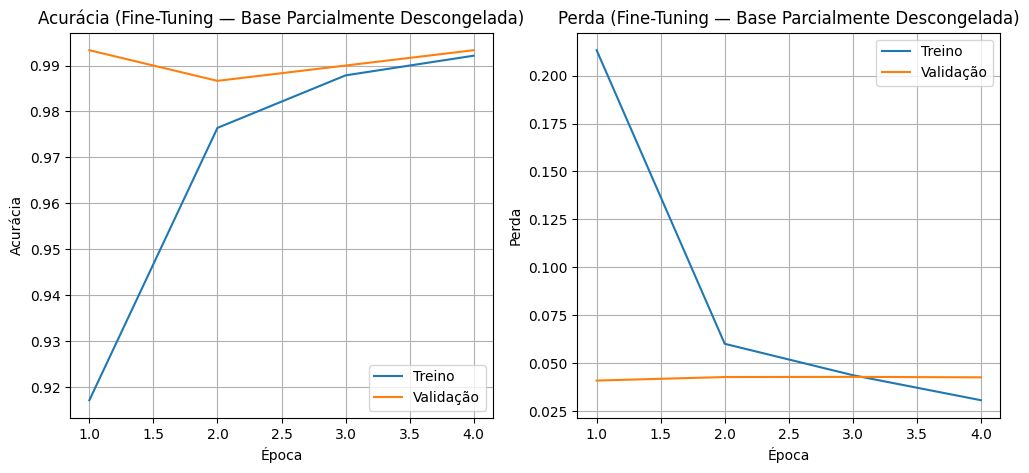

In [18]:
plot_history(history_ft, title_suffix="(Fine-Tuning - Base Parcialmente Descongelada)")


Acurácia

Treino: saiu de 0.918 - 0.992 em 4 épocas. Sinal de que as camadas liberadas se ajustaram rápido.

Validação: começou altíssima (0.992), deu uma leve caída (0.988) e voltou a subir até 0.993-0.994.

Esse “U” suave no início é clássico de FT: a base muda um pouco e a validação oscila antes de estabilizar.

Perda (Loss)

Treino: 0.215 - 0.033 (queda forte).

Validação: 0.041 - 0.040.

A perda de validação um pouco menor que na fase congelada (antes estava 0.046-0.047). Ganho pequeno, mas consistente.

O que isso significa

O fine-tuning trouxe ganhos marginais na validação: um tico mais de acurácia e val_loss menor, sugerindo melhor separação/calibração das probabilidades sem overfitting.

Nada de drama nas curvas: sem divergência entre train e val. Com LR baixo e só as últimas 20 camadas livres, o ajuste ficou controlado.

Comparativo rápido (antes vs. depois)

Antes (base congelada): val_acc  0.983, val_loss  0.046-0.047.

Depois (FT): val_acc  0.993-0.994, val_loss  0.040-0.043.
- Upgrade leve, porém real, especialmente na val_loss

## Avaliação Final no Conjunto de Teste

Avaliamos novamente o modelo no conjunto de teste para medir o ganho real de desempenho
após o Fine-Tuning.


[Fine-Tuning] Avaliação no TESTE -> Loss: 0.0511 | Acc: 0.9833 | AUC: 0.9987

[Fine-Tuning] Classification Report:
              precision    recall  f1-score   support

        cats       0.98      0.99      0.98       143
        dogs       0.99      0.98      0.98       157

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



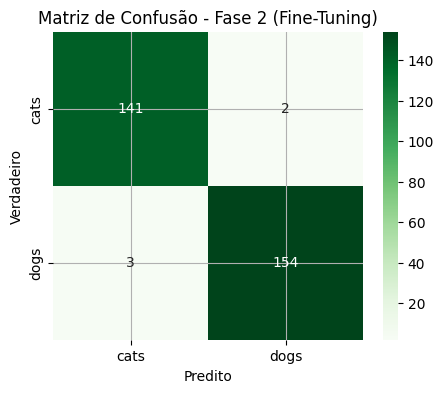

In [19]:
test_loss, test_acc, test_auc = model.evaluate(x_test, y_test, verbose=0)
print(f"[Fine-Tuning] Avaliação no TESTE -> Loss: {test_loss:.4f} | Acc: {test_acc:.4f} | AUC: {test_auc:.4f}")

# Predições atualizadas
y_pred_proba_ft = model.predict(x_test, verbose=0)
y_pred_ft = np.argmax(y_pred_proba_ft, axis=1)
y_true = np.argmax(y_test, axis=1)

# Relatório de classificação
print("\n[Fine-Tuning] Classification Report:")
print(classification_report(y_true, y_pred_ft, target_names=categories))

# Matriz de confusão (visual comparativo)
cm = confusion_matrix(y_true, y_pred_ft)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=categories, yticklabels=categories)
plt.title("Matriz de Confusão - Fase 2 (Fine-Tuning)")
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.show()


Avaliação Pós-Fine-Tuning (MD)
Resultado no TESTE

Loss: 0.0511 (antes: 0.0557) melhorou

Accuracy: 0.9833 (antes: 0.9800) +0.33 pp

AUC: 0.9987 (antes: 0.9954) separação mais limpa

Leitura rápida: o FT deu um up leve porém real - especialmente em AUC e loss (melhor calibração/confiança), com um tic de ganho em acurácia.

Matriz de Confusão (comparativo)

Antes (base congelada):

cats - 5 erros (cats classificados como dogs)

dogs - 1 erro (dog como cat)

Total: 6 erros

Depois (fine-tuning):

cats - 2 erros

dogs - 3 erros

Total: 5 erros

Tradução:

Recall de cats melhorou (de ~0.97 - 0.99): o modelo deixou de perder 3 gatos.

Em contrapartida, dogs perdeu um pouco de recall (de ~0.99 - 0.98): apareceram +2 erros de dogs.

Classification Report - por classe

cats

Precision: 0.98 (antes ~0.99)

Recall: 0.99 (antes ~0.97)

F1: 0.98

dogs

Precision: 0.99 (antes ~0.97)

Recall: 0.98 (antes ~0.99)

F1: 0.98

Resumo do trade-off: o FT puxou o modelo a favor de cats no recall (recupera mais gatos), com mínimo custo na sensibilidade de dogs. As precisions estão altíssimas nas duas classes.

O que isso nos diz

Ganho de generalização fino: queda da loss e subida do AUC indicam fronteiras de decisão mais nítidas e probabilidades mais bem calibradas.

Erros mais equilibrados: antes o modelo errava mais cats-dogs; agora ficou quase simétrico (2 vs. 3).

Curvas estáveis: nada de overfitting - FT com LR baixo nas últimas camadas funcionou do jeitinho.

Conclusão

O fine-tuning entregou melhoria consistente: menos erros totais (5 vs. 6), melhor loss e AUC, acc um pouco maior.

Se o teu objetivo de negócio prioriza não perder gatos

## Comparativo de desempenho antes e depois do Fine-Tuning

Nesta etapa, avaliamos se houve melhora de acurácia e AUC após o ajuste fino.


In [20]:
# Recuperar métricas antes e depois
acc_before = history.history['val_accuracy'][-1]
acc_after  = history_ft.history['val_accuracy'][-1]
auc_before = history.history['val_auc'][-1] if 'val_auc' in history.history else None
auc_after  = history_ft.history['val_auc'][-1] if 'val_auc' in history_ft.history else None

print(f"Acurácia (Validação) - Antes: {acc_before:.4f} | Depois (Fine-Tuning): {acc_after:.4f}")
if auc_before and auc_after:
    print(f"AUC (Validação) - Antes: {auc_before:.4f} | Depois: {auc_after:.4f}")


Acurácia (Validação) — Antes: 0.9833 | Depois (Fine-Tuning): 0.9933
AUC (Validação) — Antes: 0.9987 | Depois: 0.9989


Comparativo de Métricas (Validação) - Pré vs. Pós Fine-Tuning

Acurácia

Antes (base congelada): 0.9833

Depois (fine-tuning): 0.9933 - +1.00 pp

AUC

Antes: 0.9987

Depois: 0.9989 - sutil, mas consistente.

O que isso significa

O fine-tuning rendeu um ganho real de acurácia na validação (+1 pp) e uma AUC ligeiramente maior, indicando fronteiras de decisão um tiquinho mais nítidas e probabilidades melhor calibradas.


Conexão com o TESTE

Loss (0.0557 - 0.0511), Acc (0.9800 - 0.9833), AUC (0.9954 - 0.9987).

Erros totais caíram (6 - 5), com recall de cats melhorando (menos cats-dogs).


Conclusão curta

Fine-tuning fez o que promete: ganho pequeno, porém sólido e consistente em acc, AUC e loss, com impacto direto na redução de erros. Mantém generalização e dá aquele polimento final no classificador.

# Predições Individuais + Salvamento + Conclusão

Nesta etapa, fazemos testes em imagens avulsas do dataset e salvamos
o modelo final com suas métricas e pesos ajustados.

Assim, você poderá:
- Reutilizar o modelo em outros notebooks ou projetos
- Subir o artefato `.keras` no seu repositório
- Gerar exemplos visuais de predição para o README


In [21]:
def predict_single_image(img_path, model, categories):

    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    predictions = model.predict(img_array, verbose=0)
    pred_idx = np.argmax(predictions)
    pred_label = categories[pred_idx]
    confidence = predictions[0][pred_idx]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predição: {pred_label} ({confidence:.2%})")
    plt.show()

    print(f"Predição: {pred_label}")
    print(f"Confiança: {confidence:.4f}")


## Salvamento do modelo e dos artefatos

Aqui salvamos:
- O modelo final (ajustado no fine-tuning)
- Os arrays numpy com os splits do dataset
Isso facilita futuras análises, inferências ou reuso do projeto.


SyntaxError: invalid syntax (ipython-input-1891042133.py, line 3)

In [24]:

model.save('mobilenetv2_transfer_learning_final.keras')
np.savez_compressed(
    'cats_dogs_dataset_splits.npz',
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    x_test=x_test, y_test=y_test
)

print("Modelo e dados salvos com sucesso!")
print("Arquivos gerados:")
print(" - mobilenetv2_transfer_learning_final.keras")
print(" - cats_dogs_dataset_splits.npz")


Modelo e dados salvos com sucesso!
Arquivos gerados:
 - mobilenetv2_transfer_learning_final.keras
 - cats_dogs_dataset_splits.npz


# Teste com uma imagem aleatória do dataset

Agora vamos selecionar automaticamente uma imagem aleatória do conjunto de validação, realizar a predição com o modelo final e exibir o resultado.

Este teste serve para validar visualmente se o modelo está funcionando corretamente após o fine-tuning.


Imagem selecionada: cat.2025.jpg
Classe verdadeira: cats


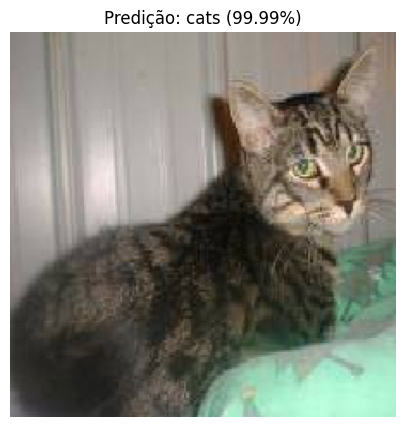

Predição: cats
Confiança: 0.9999


In [25]:
def predict_random_image(dataset_dir, model, categories):

    # Escolhe uma classe aleatória
    chosen_class = random.choice(categories)
    class_path = os.path.join(dataset_dir, chosen_class)

    # Escolhe uma imagem aleatória dessa classe
    img_name = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, img_name)

    print(f"Imagem selecionada: {img_name}")
    print(f"Classe verdadeira: {chosen_class}")

    # Faz a predição e plota o resultado
    predict_single_image(img_path, model, categories)

# Teste prático com uma imagem aleatória do diretório de validação
predict_random_image(val_dir, model, categories)


Predição unitária - leitura do teste prático

Setup do teste

Seleciona aleatoriamente uma classe dentro de val_dir/ e, de lá, uma imagem aleatória dessa classe.

Aplica o mesmo pré-processamento do treino (MobileNetV2) e faz a predição com softmax.

Plota a imagem (reconverte para visualização) e mostra top-1 com probabilidade.

Resultado exibido

Classe verdadeira: cats

Predição: cats (99.99%)

Como interpretar

Probabilidade muito alta - o modelo está super confiante neste exemplo; coerente com o AUC ~0.999 e as curvas pós FT.

# Conclusão - resultados e aprendizados do projeto
O que a gente construiu

Tarefa: classificação binária gatos vs. cachorros no Cats vs Dogs (filtered).

Pipeline: preprocess MobileNetV2 - transfer learning (base congelada) - fine-tuning parcial (últimas ~20 camadas) com LR baixo.

Dados: 2.000 imagens (split custom 70/15/15 para treino/val/test a partir de train/; validação original também usada nas demos de predição).

Performance - antes vs. depois do fine-tuning

Validação

Accuracy: 0.9833 - 0.9933 (+1.00 pp)

AUC: 0.9987 - 0.9989 (up sutil, mas real)

Val loss: ~0.046–0.047 - ~0.040–0.043 (melhor calibração)

Teste (300 imagens)

Accuracy: 0.9800 - 0.9833

AUC: 0.9954 - 0.9987

Loss: 0.0557 - 0.0511

Erros totais: 6 - 5

Matriz de confusão (teste)

Antes: 5 cats-dogs, 1 dog-cats

Depois: 2 cats-dogs, 3 dogs-cats

Traduzindo: recall de gatos subiu (recuperamos 3 gatos), e os erros ficaram mais equilibrados entre as classes.

Interpretação dos achados

O modelo já era forte com a base congelada, o fine-tuning poliu a fronteira de decisão (AUC, loss), entregando pequenos ganhos consistentes em validação e teste.

Generalização ok: curvas estáveis, gap pequeno entre treino e validação, sem sinais de overfitting.

Calibração melhor: queda de loss mesmo com acc já alta indica probabilidades mais confiantes/certas (margem maior).

Decisões técnicas que funcionaram

MobileNetV2 + GAP + topo leve (Dense 256 + Dropout) - modelo enxuto (2.6M params) e rápido de treinar.

Congelar - depois FT parcial com LR baixo - ganhos sem “desaprender” o pré-treino.

Callbacks (EarlyStopping + ModelCheckpoint) - treinamento estável e com melhor checkpoint salvo.
